In [93]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, 
                             accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Prepare Data

## Import data

In [3]:
df = pd.read_csv("data/df_clean.csv")

## Explore data

In [4]:
print("Dimensions of the dataframe")
print(df.shape)

print("Information of dataset")
print(df.info())

Dimensions of the dataframe
(8586, 19)
Information of dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age_days                            8586 non-null   int64  
 1   sex                                 8586 non-null   object 
 2   region                              8586 non-null   object 
 3   area                                8586 non-null   object 
 4   child_lenhei_cm                     8586 non-null   float64
 5   child_weight_kg                     8586 non-null   float64
 6   child_ill_cough_two_weeks           8586 non-null   object 
 7   child_ill_fever_two_weeks           8586 non-null   object 
 8   child_had_diarrhoea_last_two_weeks  8586 non-null   object 
 9   health_insurance                    8586 non-null   object 
 10  mother_educational_level            8586 non-n

In [5]:
print("The first five rows")
print(df.head())

The first five rows
   age_days     sex   region   area  child_lenhei_cm  child_weight_kg  \
0       622    Male  Western  Rural             77.8              9.5   
1       431  Female  Western  Rural             70.6              7.0   
2      1295  Female  Western  Rural             95.3             11.9   
3       532  Female  Western  Rural             78.6              9.8   
4      1607    Male  Western  Rural            100.1             14.9   

  child_ill_cough_two_weeks child_ill_fever_two_weeks  \
0                        No                        No   
1                       Yes                        No   
2                        No                       Yes   
3                        No                       Yes   
4                       Yes                        No   

  child_had_diarrhoea_last_two_weeks   health_insurance  \
0                                 No     With insurance   
1                                Yes  Without insurance   
2                    

stunting
Normal      0.82716
Stunting    0.17284
Name: proportion, dtype: float64


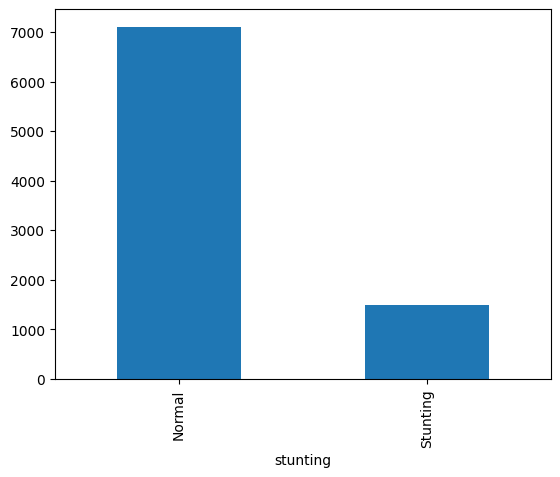

In [6]:
## Stunting
print(df["stunting"].value_counts(normalize=True))
df["stunting"].value_counts().plot(kind="bar");

wasting
Normal     0.930002
Wasting    0.069998
Name: proportion, dtype: float64


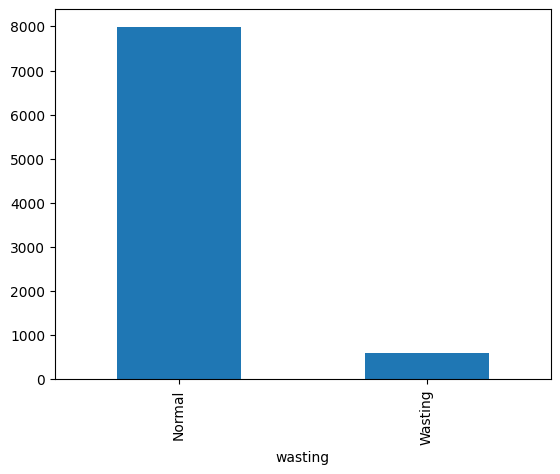

In [7]:
## Wasting
print(df["wasting"].value_counts(normalize=True))
df["wasting"].value_counts().plot(kind="bar");

underweight
Normal         0.877824
Underweight    0.122176
Name: proportion, dtype: float64


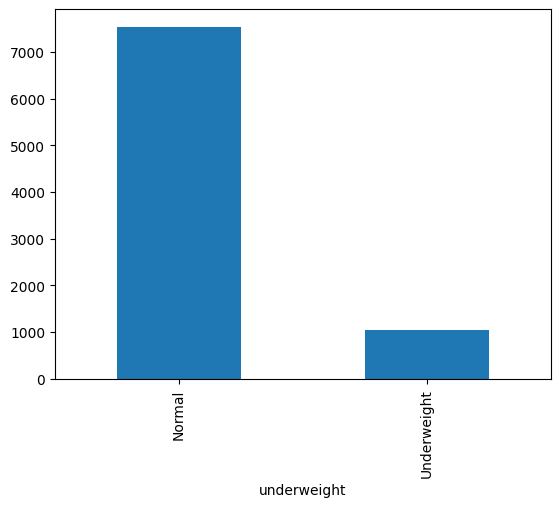

In [8]:
## Underweight
print(df["underweight"].value_counts(normalize=True))
df["underweight"].value_counts().plot(kind="bar");

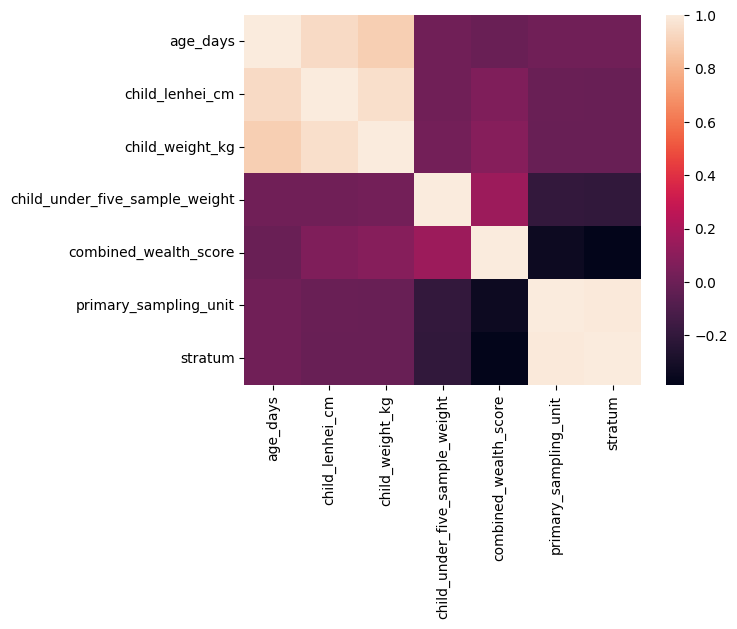

In [9]:
## Explore correlation of numeric variables
corr = df.select_dtypes("number").corr() # Find correlation of numeric variables
sns.heatmap(corr); # Plot heatmap


## Split data

In [72]:
# s: stunting; u: underweight; w: wasting
# Encode categorical features
le = LabelEncoder()

# Create feature matrix and target vectors
target_s = "stunting"
target_u = "underweight"
target_w = "wasting"

# Create target vector for each nutritional indicator
y_s = df[target_s]
y_s_encoded = le.fit_transform(y_s) # Encode target variable for stunting
y_s_encoded = pd.Series(y_s_encoded) # Convert np.array to pd.Series

## Underweight 
y_u = df[target_u]
y_u_encoded = le.fit_transform(y_u) # Encode target variable for underweight
y_u_encoded = pd.Series(y_u_encoded)  # Convert np.array to pd.Series

## Wasting
y_w = df[target_w]
y_w_encoded = le.fit_transform(y_w) # Encode target variable for wasting
y_w_encoded = pd.Series(y_w_encoded)  # Convert np.array to pd.Series

# Features
X = df.drop(columns=[target_s, target_u, target_w, "primary_sampling_unit", "stratum", "child_under_five_sample_weight"])
X.head()

,age_days,sex,region,area,child_lenhei_cm,child_weight_kg,child_ill_cough_two_weeks,child_ill_fever_two_weeks,child_had_diarrhoea_last_two_weeks,health_insurance,mother_educational_level,ethnicity,combined_wealth_score
0,622,Male,Western,Rural,77.8,9.5,No,No,No,With insurance,Jss/jhs/middle,Akan,0.153212
1,431,Female,Western,Rural,70.6,7.0,Yes,No,Yes,Without insurance,Primary,Akan,-0.068991
2,1295,Female,Western,Rural,95.3,11.9,No,Yes,No,Without insurance,Jss/jhs/middle,Akan,-0.263641
3,532,Female,Western,Rural,78.6,9.8,No,Yes,No,Without insurance,Jss/jhs/middle,Akan,-0.263641
4,1607,Male,Western,Rural,100.1,14.9,Yes,No,No,With insurance,Primary,Akan,0.087765


In [74]:
# View head of target vectors
print(y_s.head()) # Stunting
print(y_u.head()) # Underweight
print(y_w.head()) # Wasting

0    Stunting
1    Stunting
2      Normal
3      Normal
4      Normal
Name: stunting, dtype: object
0         Normal
1    Underweight
2         Normal
3         Normal
4         Normal
Name: underweight, dtype: object
0    Normal
1    Normal
2    Normal
3    Normal
4    Normal
Name: wasting, dtype: object


In [75]:
# Split data into training and test data

## Stunting
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s_encoded, test_size=0.3, random_state=42)

## Underweight
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, y_u_encoded, test_size=0.3, random_state=42)

## Wasting
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y_w_encoded, test_size=0.3, random_state=42)

## Print dimensions of stunting split
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)

# Print dimensions of underweight split
print(X_train_u.shape, X_test_u.shape, y_train_u.shape, y_test_u.shape)

# Print dimensions of wasting split
print(X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape)

(6010, 13) (2576, 13) (6010,) (2576,)
(6010, 13) (2576, 13) (6010,) (2576,)
(6010, 13) (2576, 13) (6010,) (2576,)


# Build model

## Baseline model

In [76]:
# Stunting
baseline_s = y_train_s.value_counts(normalize=True).max()
print(f"Baseline accuracy for stunting is: {baseline_s}")

# Underweight
baseline_u = y_train_u.value_counts(normalize=True).max()
print(f"Baseline accuracy for underweight is: {baseline_u}")

# Wasting
baseline_w = y_train_w.value_counts(normalize=True).max()
print(f"Baseline accuracy for wasting is: {baseline_w}")

Baseline accuracy for stunting is: 0.8299500831946756
Baseline accuracy for underweight is: 0.8810316139767055
Baseline accuracy for wasting is: 0.9287853577371048


## Iterate

In [77]:
# Initialise models


# Numeric features
numeric_features = ["age_days",  
                    "child_lenhei_cm",
                    "child_weight_kg",  
                    "combined_wealth_score"]

# Categorical features
categorical_features = [
    "sex",
    "region",
    "area",
    "child_ill_cough_two_weeks",
    "child_ill_fever_two_weeks",
    "child_had_diarrhoea_last_two_weeks",
    "health_insurance",
    "mother_educational_level",
    "ethnicity"
]

# Create transformers for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

## Logistic regression
lr = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=42, max_iter=1000)
)

## Linear Discriminant Analysis
lda = make_pipeline(
                    OneHotEncoder(use_cat_names=True),
                    LinearDiscriminantAnalysis()
)

## Ridge Classifier
rr = make_pipeline(
    preprocessor,
                   RidgeClassifier(random_state=42)
)



## Support Vector Machines
svm = make_pipeline(
    preprocessor,
                    SVC(random_state=42)
)

## Random Forest
rf = make_pipeline(
    OneHotEncoder(),
    RandomForestClassifier(random_state=42),
)

## XGBoost
xgb  = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    XGBClassifier(random_state=42)
)

### Modeling: Stunting

In [78]:
# Logistic Regression
lr.fit(X_train_s, y_train_s)

# Linear Discriminant Analysis
lda.fit(X_train_s, y_train_s)

# Ridge Classifier
rr.fit(X_train_s, y_train_s)

# Support Vector Machines
svm.fit(X_train_s, y_train_s)

# Random Forest 
rf.fit(X_train_s, y_train_s)

# XGB
xgb.fit(X_train_s, y_train_s)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'region', 'area',
                                     'child_ill_cough_two_weeks',
                                     'child_ill_fever_two_weeks',
                                     'child_had_diarrhoea_last_two_weeks',
                                     'health_insurance',
                                     'mother_educational_level', 'ethnicity'],
                               use_cat_names=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [96]:
# Evaluate models on training dataset
## Logistic Regression
y_train_pred_lr = lr.predict(X_train_s)
accuracy_lr = accuracy_score(y_train_s, y_train_pred_lr)
print("Accuracy of logistic regression:", accuracy_lr)
precision_lr = precision_score(y_train_s, y_train_pred_lr)
recall_lr = recall_score(y_train_s, y_train_pred_lr)
f1_lr = f1_score(y_train_s, y_train_pred_lr)
print("Precision LR:", precision_lr)
print("Recall LR:", recall_lr)
print("F1 Score LR:", f1_lr)


# LDA
y_train_pred_lda = lda.predict(X_train_s)
accuracy_lda = accuracy_score(y_train_s, y_train_pred_lda)
print("Accuracy of LDA:", accuracy_lda)
precision_lda = precision_score(y_train_s, y_train_pred_lda)
recall_lda = recall_score(y_train_s, y_train_pred_lda)
f1_lda = f1_score(y_train_s, y_train_pred_lda)
print("Precision LDA:", precision_lda)
print("Recall LDA:", recall_lda)
print("F1 Score LDA:", f1_lda)


# Ridge classifier
y_train_pred_rr = rr.predict(X_train_s)
accuracy_rr = accuracy_score(y_train_s, y_train_pred_rr)
print("Accuracy of Ridge classifier:", accuracy_rr)
precision_rr = precision_score(y_train_s, y_train_pred_rr)
recall_rr = recall_score(y_train_s, y_train_pred_rr)
f1_rr = f1_score(y_train_s, y_train_pred_rr)
print("Precision RR:", precision_rr)
print("Recall RR:", recall_rr)
print("F1 Score RR:", f1_rr)

# Support Vector Machine
y_train_pred_svm = svm.predict(X_train_s)
accuracy_svm = accuracy_score(y_train_s, y_train_pred_svm)
print("Accuracy of Support Vector Machines:", accuracy_svm)
precision_svm = precision_score(y_train_s, y_train_pred_svm)
recall_svm = recall_score(y_train_s, y_train_pred_svm)
f1_svm = f1_score(y_train_s, y_train_pred_svm)
print("Precision SVM:", precision_svm)
print("Recall SVM:", recall_svm)
print("F1 Score SVM:", f1_svm)

# Random Forest Classifier
y_train_pred_rf = rf.predict(X_train_s)
accuracy_rf = accuracy_score(y_train_s, y_train_pred_rf)
print("Accuracy of Random Forest Classifier:", accuracy_rf)
precision_rf = precision_score(y_train_s, y_train_pred_rf)
recall_rf = recall_score(y_train_s, y_train_pred_rf)
f1_rf = f1_score(y_train_s, y_train_pred_rf)
print("Precision RF:", precision_rf)
print("Recall RF:", recall_rf)
print("F1 Score RF:", f1_rf)

# XGB
y_train_pred_xgb = xgb.predict(X_train_s)
accuracy_xgb = accuracy_score(y_train_s, y_train_pred_xgb)
print("Accuracy of Extreme Gradient Boosting:", accuracy_xgb)
precision_xgb = precision_score(y_train_s, y_train_pred_xgb)
recall_xgb = recall_score(y_train_s, y_train_pred_xgb)
f1_xgb = f1_score(y_train_s, y_train_pred_xgb)
print("Precision XGB:", precision_xgb)
print("Recall XGB:", recall_xgb)
print("F1 Score XGB:", f1_xgb)

Accuracy of logistic regression: 0.8667221297836939
Precision LR: 0.671850699844479
Recall LR: 0.4227005870841487
F1 Score LR: 0.518918918918919
Accuracy of LDA: 0.8660565723793677
Precision LDA: 0.6697965571205008
Recall LDA: 0.4187866927592955
F1 Score LDA: 0.5153521974714027
Accuracy of Ridge classifier: 0.8612312811980033
Precision RR: 0.7568306010928961
Recall RR: 0.2710371819960861
F1 Score RR: 0.39913544668587897
Accuracy of Support Vector Machines: 0.9540765391014975
Precision SVM: 0.9882198952879581
Recall SVM: 0.738747553816047
F1 Score SVM: 0.845464725643897
Accuracy of Random Forest Classifier: 1.0
Precision RF: 1.0
Recall RF: 1.0
F1 Score RF: 1.0
Accuracy of Extreme Gradient Boosting: 1.0
Precision XGB: 1.0
Recall XGB: 1.0
F1 Score XGB: 1.0


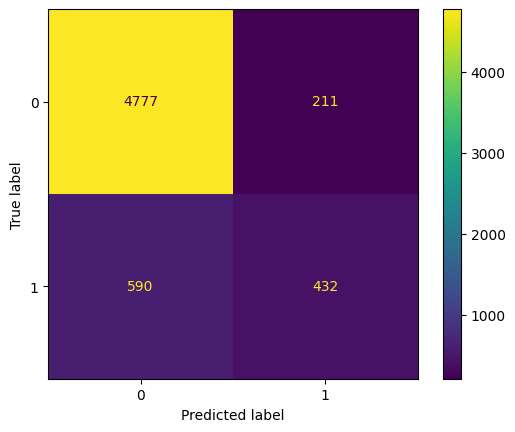

In [87]:
## Confusion Matrix

## Logistic Regression
cm_lr = confusion_matrix(y_train_s, y_train_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp.plot();

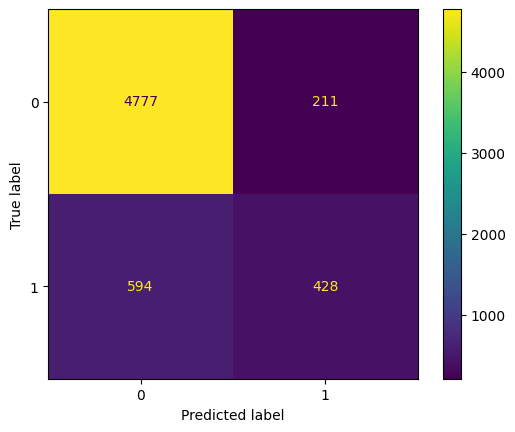

In [88]:
# LDA
cm_lda = confusion_matrix(y_train_s, y_train_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lda)
disp.plot();

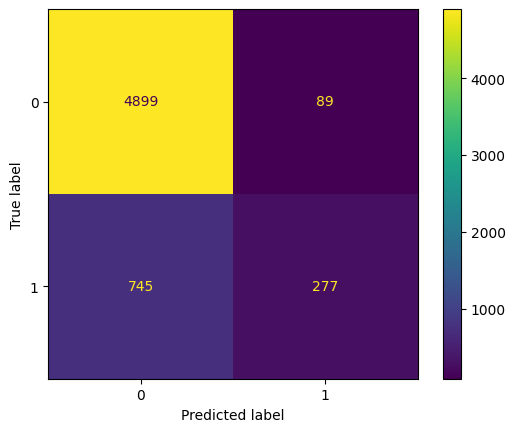

In [89]:
# Ridge classifier
cm_rr = confusion_matrix(y_train_s, y_train_pred_rr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rr)
disp.plot();

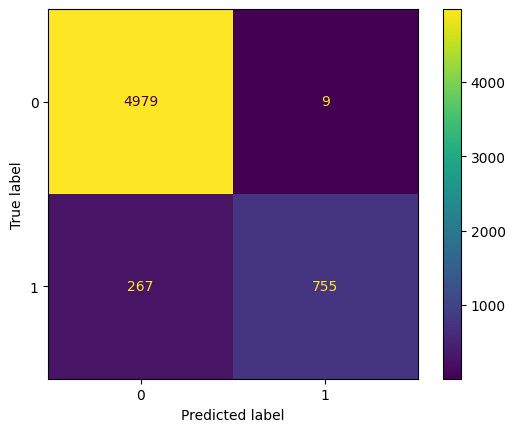

In [90]:
# Support Vector Machines
cm_svm = confusion_matrix(y_train_s, y_train_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp.plot();

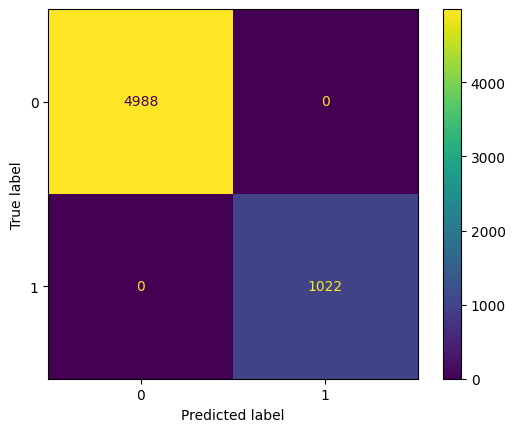

In [91]:
# Random Forest Classifier
cm_rf = confusion_matrix(y_train_s, y_train_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot();

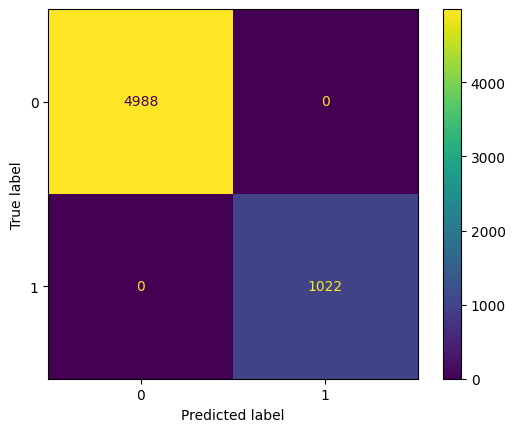

In [92]:
# XGB
cm_xgb = confusion_matrix(y_train_s, y_train_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot();

In [94]:
# Logistic Regression
accuracy_lr = accuracy_score(y_train_s, y_train_pred_lr)
print("Accuracy of logistic regression:", accuracy_lr)


# LDA

# Ridge classifier

# Support Vector Machine

# Random Forest Classifier

# XGB


Accuracy of logistic regression: 0.8667221297836939
Precision LR: 0.671850699844479
Recall LR: 0.4227005870841487
F1 Score LR: 0.518918918918919


## Evaluate